Seeks to aid in understanding the binning of the power spectrum in nbodykit_pk.binned_pk

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
from nbodykit.lab import *
from nbodykit import style, setup_logging
#setup_logging()
import matplotlib.pyplot as plt
plt.style.use(style.notebook)

### Set up mock catalog and find power spectrum

In [9]:
BoxSize = 1380
Nmesh = 256

redshift = 0
cosmo = cosmology.Planck15
Plin = cosmology.LinearPower(cosmo, redshift, transfer="EisensteinHu")

cat = LogNormalCatalog(Plin=Plin, nbar=3e-4, BoxSize=BoxSize, Nmesh=Nmesh, seed=42)
mesh = cat.to_mesh(resampler='tsc', compensated=True, position='Position')

r = FFTPower(mesh, mode='1d', dk=0.005, kmin=0.01)
Pk = r.power

### Reproducing binned_pk function
Idea: Count how many times within a k bin the power spectrum has been evaluated. The binned power spectrum will be an array with one value of the power associated to each bin. This value is found the following way:
- mode counts the number of times the power spectrum has been evaluated in a bin i.e. each occurrence increases the count by 1. 
- pkbin does the same but each occurrence increases the count by the value of the power.
The binned value of the power is the average power per occurrence and thus found by pkbin/mode. Note that it is possible that there are 0 occurrences inside a bin. For example when the bin lies outside the range of ks at which FFT is computed. A second instance producing 0 occurrences is important for log binning and explained below. `np.where` doesn't treat the $0/0$ error that occurs correctly. Hence use `np.divide`.   

In [66]:
k_Nyq = np.pi*Nmesh/BoxSize
k_min = 0.005
k_max = k_Nyq*1.05 
Nk = 30 

kbin = kbin=[k_min,k_max,Nk,'lin']

if(kbin[3]=='lin'):
    kbin_ed=np.linspace(kbin[0],kbin[1],kbin[2])
elif(kbin[3]=='log'):
    kbin_ed=np.power(10,np.linspace(np.log10(kbin[0]),np.log10(kbin[1]),kbin[2]))

- linear binning: Nk bins with edges equally separated between min and max k.

- log binning (The same edges are produced when using any other exponential base and the associated logarithm.): Creates Nk linearly spaced values between log10(kmin) and log10(kmax). Edges of the binning are the defined as 10 to the power of the previously calculated values. These start with kmin and end with kmax but increase exponentially in size. Hence there is a finner binning for small k than there is for large k. Depending on how fine the FFT is computed, the fine binning at small k causes some bins to contain 1 data point while its neighbors (and their neighbors too) don't contain any data points at all. This causes the binned power spectrum to appear ragged at small k. 

In [67]:
pk_out=np.column_stack([Pk['k'], Pk['power'].real - Pk.attrs['shotnoise']])

mode,hh=np.histogram(pk_out[:,0],bins=kbin_ed)
pkbin,hh=np.histogram(pk_out[:,0],bins=kbin_ed,weights=pk_out[:,1])

In [68]:
print("First bin edges: ", kbin_ed[:7])
print("Frist k values of FFT; ", pk_out[:,0][:15])
print("mode: ", mode)

First bin edges:  [0.005      0.02592854 0.04685708 0.06778562 0.08871415 0.10964269
 0.13057123]
Frist k values of FFT;  [0.01247248 0.01780909 0.02302673 0.02797374 0.03277947 0.03784359
 0.04254636 0.04736247 0.05233874 0.05746298 0.06257337 0.06756338
 0.07265461 0.07761458 0.08253154]
mode:  [3 4 5 4 4 4 4 4 5 4 4 4 4 5 4 4 4 4 5 4 4 4 4 4 5 4 4 3 0]


In [69]:
kbin_mid=0.5*(kbin_ed[1:]+kbin_ed[:-1])
pkbin = np.divide(pkbin, mode, out=np.zeros(pkbin.shape), where=mode!=0)

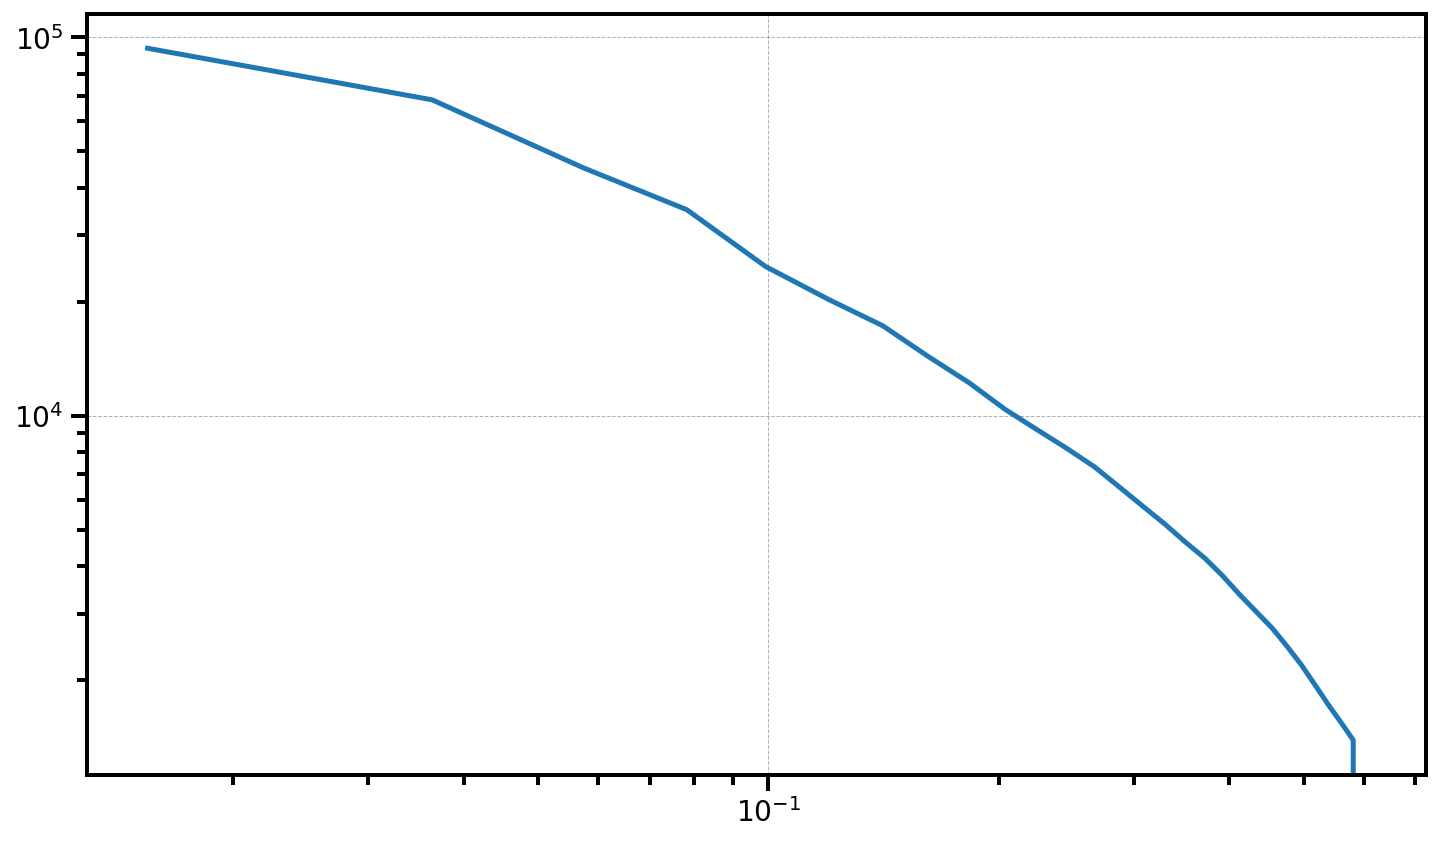

In [70]:
plt.loglog(kbin_mid, pkbin)